# Visualize Results: Impute Performance - "Corrupted" Experiment

This notebook should answer the questions: *Which imputer works best to re-construct missing values?*

## Notebook Structure 

* Application Scenario 1 - Imputation Performance 
   * Categorical  Columns (Classification)
   * Numerical Columns (Regression)
   * Heterogenous Columns (Classification and Regression Combined)

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import seaborn as sns

from pathlib import Path
from data_imputation_paper.experiment import read_experiment, read_csv_files
from data_imputation_paper.plotting import plot_metric_vs_missing_fraction, plot_rank_vs_fraction_by_type, draw_cat_box_plot

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Settings

In [2]:
sns.set(style="whitegrid")
sns.set_context('paper', font_scale=1.5)
mpl.rcParams['lines.linewidth'] = '2'

In [90]:
EXPERIMENT = "corrupted"

EXPERIMENT_PATH = Path(f"../data/experiments/{EXPERIMENT}/")

IMPUTE_RESULT_TYPE = "impute_performance_mean"
FIGURES_PATH = Path("../paper/figures/")

CLF_METRIC = "Categorical Columns"
REG_METRIC = "Numerical Columns"

CONFIDENCE_INTERVAL = 90

## Import the data

In [4]:
%%time

results = read_csv_files(read_experiment(EXPERIMENT_PATH), read_details=False)
results.head()

CPU times: user 1min 26s, sys: 3.5 s, total: 1min 29s
Wall time: 1min 37s


,experiment,imputer,task,missing_type,missing_fraction,strategy,column,result_type,metric,train,test,baseline,corrupted,imputed
0,corrupted,AutoKerasImputer,40922,MCAR,0.01,single_all,gyro_y,impute_performance_std,MAE,0.607368,1.539765,NaN,NaN,NaN
1,corrupted,AutoKerasImputer,40922,MCAR,0.01,single_all,gyro_y,impute_performance_std,MSE,10.799949,33.292381,NaN,NaN,NaN
2,corrupted,AutoKerasImputer,40922,MCAR,0.01,single_all,gyro_y,impute_performance_std,RMSE,0.606519,2.002486,NaN,NaN,NaN
3,corrupted,AutoKerasImputer,40922,MCAR,0.30,single_all,gyro_y,impute_performance_std,MAE,0.179147,0.123156,NaN,NaN,NaN
4,corrupted,AutoKerasImputer,40922,MCAR,0.30,single_all,gyro_y,impute_performance_std,MSE,4.434295,4.787317,NaN,NaN,NaN


In [99]:
impute_results = results[
    (results["result_type"] == IMPUTE_RESULT_TYPE) & 
    (results["metric"].isin(["F1_macro", "MAE"]))
]
assert len(results["strategy"].unique()) == 1
impute_results.drop(["experiment", "train", "strategy", "baseline", "corrupted", "imputed"], axis=1, inplace=True) 
impute_results = impute_results.rename(
    {
        "imputer": "Imputation Method",
        "task": "Task",
        "missing_type": "Missing Type",
        "missing_fraction": "Missing Fraction",
        "column": "Column",
        "test": "Imputation"
    },
    axis = 1
)

In [100]:
rename_imputer_dict = {
    "ModeImputer": "Mean/Mode",
    "KNNImputer": "$k$-NN",
    "ForestImputer": "Random Forest",
    "AutoKerasImputer": "Discriminate DL",
    "VAEImputer": "VAE",
    "GAINImputer": "GAIN"    
}

rename_metric_dict = {
    "F1_macro": CLF_METRIC,
    "MAE": REG_METRIC
}

impute_results = impute_results.replace(rename_imputer_dict)
impute_results = impute_results.replace(rename_metric_dict)

impute_results.head()

,Imputation Method,Task,Missing Type,Missing Fraction,Column,result_type,metric,Imputation
14790,Discriminate DL,40922,MCAR,0.01,gyro_y,impute_performance_mean,Numerical Columns,6.506668
14793,Discriminate DL,40922,MCAR,0.30,gyro_y,impute_performance_mean,Numerical Columns,6.178070
14796,Discriminate DL,40922,MCAR,0.50,gyro_y,impute_performance_mean,Numerical Columns,6.356191
14799,Discriminate DL,40922,MCAR,0.10,gyro_y,impute_performance_mean,Numerical Columns,6.439587
14802,Discriminate DL,40922,MNAR,0.01,gyro_y,impute_performance_mean,Numerical Columns,9.185541


## Compute Imputer Ranking

In [101]:
EXPERIMENTAL_CONDITIONS = ["Task", "Missing Type", "Missing Fraction", "Column", "result_type", "metric"]

clf_row_idx = impute_results["metric"] == CLF_METRIC
reg_row_idx = impute_results["metric"] == REG_METRIC

In [102]:
impute_results.loc[clf_row_idx, "Imputation Rank"] = impute_results[clf_row_idx].groupby(EXPERIMENTAL_CONDITIONS).rank(ascending=False, na_option="bottom", method="min")["Imputation"]
impute_results.loc[reg_row_idx, "Imputation Rank"] = impute_results[reg_row_idx].groupby(EXPERIMENTAL_CONDITIONS).rank(ascending=True, na_option="bottom", method="min")["Imputation"]
impute_results

,Imputation Method,Task,Missing Type,Missing Fraction,Column,result_type,metric,Imputation,Imputation Rank
14790,Discriminate DL,40922,MCAR,0.01,gyro_y,impute_performance_mean,Numerical Columns,6.506668,2.0
14793,Discriminate DL,40922,MCAR,0.30,gyro_y,impute_performance_mean,Numerical Columns,6.178070,2.0
14796,Discriminate DL,40922,MCAR,0.50,gyro_y,impute_performance_mean,Numerical Columns,6.356191,2.0
14799,Discriminate DL,40922,MCAR,0.10,gyro_y,impute_performance_mean,Numerical Columns,6.439587,2.0
14802,Discriminate DL,40922,MNAR,0.01,gyro_y,impute_performance_mean,Numerical Columns,9.185541,4.0
...,...,...,...,...,...,...,...,...,...
29565,GAIN,1220,MCAR,0.10,keyword_id,impute_performance_mean,Numerical Columns,37303.931237,4.0
29568,GAIN,1220,MNAR,0.01,keyword_id,impute_performance_mean,Numerical Columns,41814.662191,6.0
29571,GAIN,1220,MNAR,0.30,keyword_id,impute_performance_mean,Numerical Columns,47023.136841,6.0
29574,GAIN,1220,MNAR,0.50,keyword_id,impute_performance_mean,Numerical Columns,55723.836215,6.0


### Check if results are complete

In [103]:
# should have equal length
impute_results["Imputation Method"].value_counts(dropna=False)

VAE                828
Random Forest      828
Mean/Mode          828
GAIN               828
$k$-NN             828
Discriminate DL    790
Name: Imputation Method, dtype: int64

### Robustness: check which imputers yielded `NaN` values

In [104]:
for col in impute_results.columns:
    na_sum = impute_results[col].isna().sum()
    if na_sum > 0:
        print("-----" * 10)        
        print(col, na_sum)
        print("-----" * 10)        
        na_idx = impute_results[col].isna()
        print(impute_results.loc[na_idx, "Imputation Method"].value_counts(dropna=False))
        print("\n")

## Application Scenario 1 - Imputation Performance

In [105]:
impute_results.groupby(["metric"]).size()

metric
Categorical Columns     637
Numerical Columns      4293
dtype: int64

The data is not equally distributed between categorical and numerical imputation tasks, so simply averaging the ranks, as done in the plots below, could be misleading.

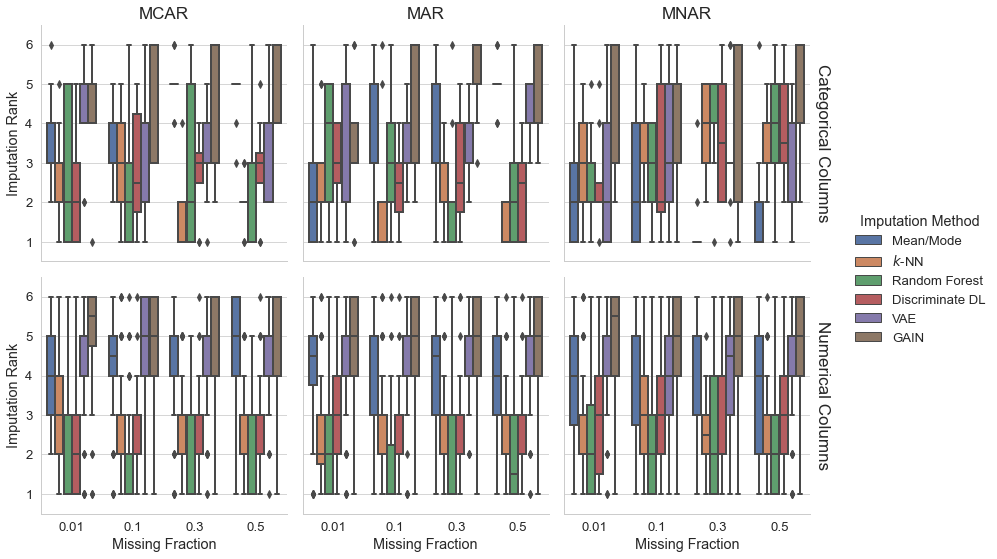

In [106]:
draw_cat_box_plot(
    impute_results,
    "Imputation Rank",
    (0.5, 6.5),
    FIGURES_PATH,
    "corrupted_impute_rank_boxplot.eps",
    hue_order=list(rename_imputer_dict.values()),
    row_order=list(rename_metric_dict.values())
)